In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipykernel_889/1319117283.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Create Gaussian blurs with varying widths and occluding bars

In [2]:
nGauss  = 1000
imgSize = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# vary the weights smoothly
widths = np.linspace(2,20,nGauss)

# initialize tensor containing images
images = torch.zeros(nGauss,1,imgSize,imgSize)

for i in range(nGauss):

  # create the gaussian with random centers
  ro = 1.5*np.random.randn(2) # ro = random offset
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / widths[i] )
  
  # and add noise
  G  = G + np.random.randn(imgSize,imgSize)/5

  # add a random bar randomly
  i1 = np.random.choice(np.arange(2,28))
  i2 = np.random.choice(np.arange(2,6))
  if np.random.randn()>0:
    G[i1:i1+i2,] = 1
  else:
    G[:,i1:i1+i2] = 1
  
  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

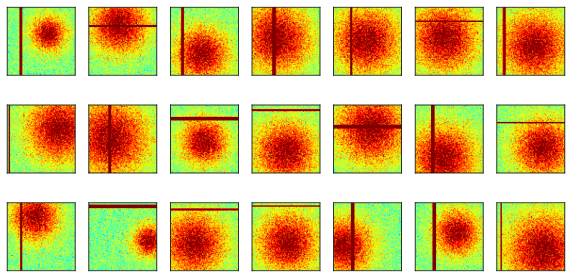

In [3]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(10,5))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(nGauss)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Custom loss functions

The code snippet defines a custom loss function class, `myL1Loss`, using PyTorch's neural network module (`nn.Module`). This class implements the L1 loss, also known as the Mean Absolute Error (MAE), a commonly used loss function for regression tasks. The L1 loss measures the average magnitude of the absolute differences between predicted values (\( \hat{y} \)) and actual values (\( y \)) across all samples in the dataset. Here's an overview of the class and its functionality:

- **Class Definition**: The `myL1Loss` class inherits from `nn.Module`, the base class for all neural network modules in PyTorch. This inheritance allows the custom loss function to seamlessly integrate with other PyTorch components and training procedures.

- **Forward Method**: The `forward` method computes the L1 loss between the predicted values (\( \hat{y} \)) and the ground truth (\( y \)). It takes two arguments: `yHat`, the predictions made by the model, and `y`, the actual values.

- **Loss Computation**: The loss is calculated by first taking the absolute difference between the predicted and actual values (`torch.abs(yHat-y)`), then computing the mean of these absolute differences across all samples (`torch.mean(...)`). 

The L1 loss formula is refined and clearly presented as:

$$
L = \frac{1}{N} \sum_{i=1}^{N} | \hat{y}_i - y_i |
$$

where \( L \) represents the loss, \( N \) denotes the number of samples, \( \hat{y}_i \) are the predicted values, and \( y_i \) are the actual target values.

This custom L1 loss function is especially beneficial in scenarios with outliers present in the data, as it is less sensitive to outliers than the L2 loss (Mean Squared Error). Focusing on the median of the residuals rather than the mean, the L1 loss provides robustness against anomalies or non


This custom L1 loss function is especially beneficial in scenarios with outliers present in the data, as it is less sensitive to outliers than the L2 loss (Mean Squared Error). Focusing on the median of the residuals rather than the mean, the L1 loss provides robustness against anomalies or non-Gaussian noise distributions.


In [4]:
# L1 loss function

class myL1Loss(nn.Module):
  def __init__(self):
    super().__init__()
      
  def forward(self,yHat,y):
    l = torch.mean( torch.abs(yHat-y) )
    return l

The code defines a custom loss function, `myL2AveLoss`, as a subclass of PyTorch's `nn.Module`. This loss function combines the L2 loss (Mean Squared Error, MSE) with the mean of the absolute values of the predicted outputs. It is designed to penalize the model both for inaccuracies in prediction (via the MSE) and for deviating significantly from zero in its predictions (via the mean of the absolute values). Here's a breakdown of its components and the formula it implements:

- **Class Definition**: `myL2AveLoss` inherits from PyTorch's neural network module, allowing it to be seamlessly integrated into a training loop. This structure is essential for custom loss functions in PyTorch, facilitating their use with automatic differentiation.

- **Forward Method**: The `forward` method calculates the custom loss given the predicted values \( \hat{y} \) and the actual values \( y \). It comprises two parts: the MSE component and the average absolute value component.

- **MSE Component**: This part computes the mean squared difference between the predicted and actual values, defined as:
$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (\hat{y}_i - y_i)^2
$$
where \( N \) is the number of samples, \( \hat{y}_i \) are the predicted values, and \( y_i \) are the actual values.

- **Average Absolute Value Component**: The second part of the loss calculates the absolute mean of the predicted values, \( a \), emphasizing the model's bias towards non-zero predictions:
$$
a = \left| \frac{1}{N} \sum_{i=1}^{N} \hat{y}_i \right|
$$

- **Total Loss**: The final loss is the sum of the MSE component and the average absolute value component, represented by the formula:
$$
L = \text{MSE} + a
$$

This custom loss function, `myL2AveLoss`, is particularly useful in scenarios where it is crucial not


In [5]:
# L2+average loss function

class myL2AveLoss(nn.Module):
  def __init__(self):
    super().__init__()
      
  def forward(self,yHat,y):
    # MSE part
    l = torch.mean( (yHat-y)**2 )

    # average part
    a = torch.abs(torch.mean(yHat))

    # sum together
    return l + a

The code snippet introduces `myCorLoss`, a custom loss function class that extends PyTorch's `nn.Module`. This class implements a loss based on the correlation between the predicted values and actual values, which is a less common approach in typical loss functions but can be particularly useful in certain applications where the relationship between variables is of interest. Here is an explanation of its structure and computation:

- **Class Definition**: `myCorLoss` inherits from PyTorch's `nn.Module`, enabling compatibility and easy integration with PyTorch's training framework. 

- **Forward Method**: The `forward` method computes the loss by first calculating the mean of the predicted values \( \hat{y} \) and the actual values \( y \), then determining the numerator as the sum of the element-wise product of the deviations from their respective means.

- **Loss Computation**: The correlation-based loss is calculated using the formula:
$$
L = - \frac{ \sum ( \hat{y}_i - \bar{\hat{y}} ) ( y_i - \bar{y} ) }{ (n - 1) \cdot \sigma_{\hat{y}} \cdot \sigma_{y} }
$$
where \( L \) represents the loss, \( n \) is the number of elements in \( y \), \( \bar{\hat{y}} \) and \( \bar{y} \) are the means of the predicted and actual values respectively, \( \sigma_{\hat{y}} \) and \( \sigma_{y} \) are the standard deviations of the predicted and actual values respectively, and \( \hat{y}_i \) and \( y_i \) are the individual predicted and actual values.

- **Sign of the Loss**: The negative sign in front of the ratio inverts the correlation coefficient, turning it into a loss that decreases (improves) as the correlation between predictions and actual values increases. This is because a higher positive correlation (closer to 1) is generally desired, indicating that the predictions are in agreement with the actual values.

This custom `myCorLoss` function can be particularly beneficial in scenarios where maintaining a strong correlation between predictions and actual outcomes is more important than minimizing their absolute or squared differences.


In [6]:
# correlation loss function

class myCorLoss(nn.Module):
  def __init__(self):
    super().__init__()
      
  def forward(self,yHat,y):
    
    meanx = torch.mean(yHat)
    meany = torch.mean(y)

    num = torch.sum( (yHat-meanx)*(y-meany) )
    den = (torch.numel(y)-1) * torch.std(yHat) * torch.std(y)
    return -num/den

In [7]:
class VarianceLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, yHat, y):
        """
        Loss function that minimizes the variance of the model's output.
        
        Parameters:
        -----------
        output : torch.Tensor
            The model's predicted output
        target : torch.Tensor
            The target/ground truth data
        
        Returns:
        --------
        torch.Tensor: Variance minimization loss
        """
        # Calculate the mean of the output
        yHat_mean = torch.mean(yHat)
        
        # Calculate the variance of the output
        # Variance = mean of squared differences from the mean
        variance_loss = torch.mean((yHat - yHat_mean)**2)
        
        return variance_loss

def myVarianceLoss():
    """
    Wrapper function to create the variance loss function.
    
    Returns:
    --------
    VarianceLoss: Instantiated variance loss function
    """
    return VarianceLoss()

# Create the DL model

In [8]:
# create a class for the model
def makeTheNet(loss_type='mse'):

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()
      
      # encoding layer
      self.enc = nn.Sequential(
          nn.Conv2d(1,6,3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2,2),
          nn.Conv2d(6,4,3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2,2)  
          )
      
      # decoding layer
      self.dec = nn.Sequential(
          nn.ConvTranspose2d(4,6,3,2),
          nn.ReLU(),
          nn.ConvTranspose2d(6,1,3,2),
          )
      
    def forward(self,x):
      return self.dec( self.enc(x) )
  
  # create the model instance
  net = gausnet()
  
  # loss functions (leave one uncommented!)
  # Select loss function based on input parameter
  if loss_type == 'mse':
    lossfun = nn.MSELoss()
  elif loss_type == 'l1':
    lossfun = myL1Loss()
  elif loss_type == 'l2ave':
    lossfun = myL2AveLoss()
  elif loss_type == 'cor':
    lossfun = myCorLoss()
  elif loss_type == 'variance':
    lossfun = myVarianceLoss()
  else:
    raise ValueError(f"Unsupported loss type: {loss_type}. "
                     "Choose from 'mse', 'l1', 'l2ave', 'cor', 'variance'.")

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

# Create a function that trains the model

# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 1000
  
  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # initialize losses
  losses = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # pick a set of images at random
    pics2use = np.random.choice(nGauss,size=32,replace=False)
    X = images[pics2use,:,:,:]

    # forward pass and loss
    yHat = net(X)
    loss = lossfun(yHat,X)
    losses[epochi] = loss.item()

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # end epochs

  # function output
  return losses,net

# Run the model and show the results!

# train the model!
losses,net = function2trainTheModel()

plt.plot(losses,'s-',label='Train')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.title('Model loss (final loss=%.3f)'%losses[-1])

plt.show()

Final Losses:
MSE Loss: 0.0442
L1 Loss: 0.1668
L2AVE Loss: 0.1864
COR Loss: -0.8356
VARIANCE Loss: 0.0000


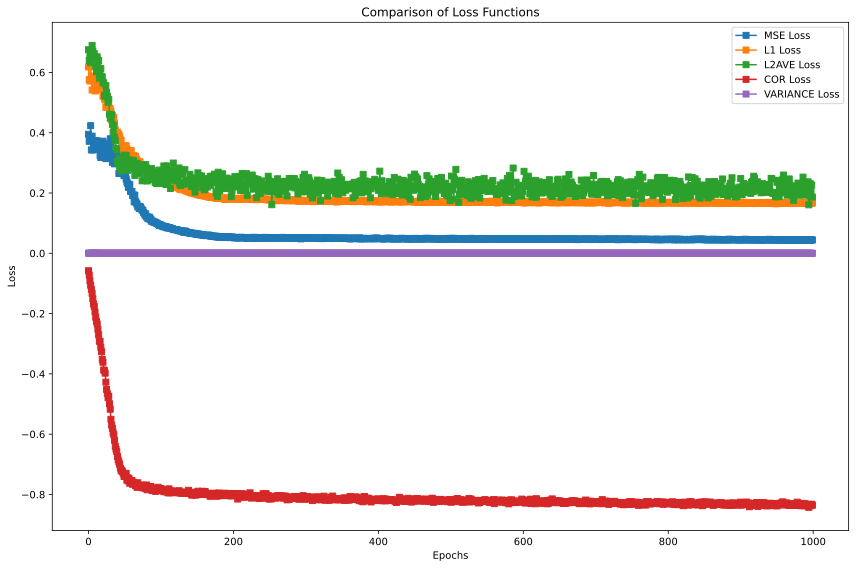

In [9]:
def train_model_with_loss(loss_type, images, nGauss):
    """
    Train the model with a specific loss function.
    
    Parameters:
    -----------
    loss_type : str
        Type of loss function to use
    images : torch.Tensor
        Training images
    nGauss : int
        Number of Gaussian images
    
    Returns:
    --------
    torch.Tensor: Losses over epochs
    """
    # number of epochs
    numepochs = 1000
    
    # create a new model with specified loss function
    net, lossfun, optimizer = makeTheNet(loss_type)

    # initialize losses
    losses = torch.zeros(numepochs)

    # loop over epochs
    for epochi in range(numepochs):
        # pick a set of images at random
        pics2use = np.random.choice(nGauss, size=32, replace=False)
        X = images[pics2use,:,:,:]

        # forward pass and loss
        yHat = net(X)
        loss = lossfun(yHat, X)
        losses[epochi] = loss.item()

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return net, losses

def compare_loss_functions(images, nGauss):
    """
    Compare multiple loss functions by training and plotting their losses.
    
    Parameters:
    -----------
    images : torch.Tensor
        Training images
    nGauss : int
        Number of Gaussian images
    """
    # List of loss functions to compare
    loss_types = ['mse', 'l1', 'l2ave', 'cor', 'variance']
    
    # Create a figure with subplots
    plt.figure(figsize=(12, 8))
    
    # Store final losses for comparison
    final_losses = {}

    nets = []
    
    # Train and plot for each loss function
    for loss_type in loss_types:
        # Train the model with the specific loss function
        net, losses = train_model_with_loss(loss_type, images, nGauss)
        
        # Plot the losses
        plt.plot(losses, 's-', label=f'{loss_type.upper()} Loss')
        
        # Store final loss for reporting
        final_losses[loss_type] = losses[-1]

        nets.append(net)
    
    # Customize the plot
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Comparison of Loss Functions')
    plt.legend()
    plt.tight_layout()
    
    # Print final losses
    print("Final Losses:")
    for loss_type, final_loss in final_losses.items():
        print(f"{loss_type.upper()} Loss: {final_loss:.4f}")
    
    plt.show()

    return nets

# Call the comparison function
nets = compare_loss_functions(images, nGauss)

<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_889/4200326234.py:18: SyntaxWarning: invalid escape sequence '\m'
  axs[0,i].set_title('Input ($\mu$=%.2f)'%torch.mean(G).item(),fontsize=10)
/tmp/ipykernel_889/4200326234.py:22: SyntaxWarning: invalid escape sequence '\m'
  axs[1,i].set_title('Output ($\mu$=%.2f)'%torch.mean(O).item(),fontsize=10)


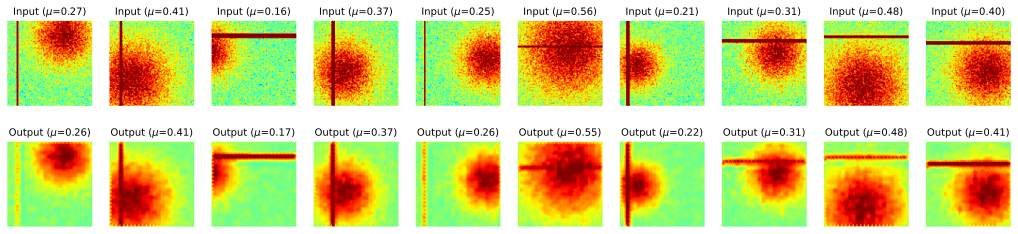

In [11]:
# visualize some images

net = nets[1] # loss_types = ['mse', 'l1', 'l2ave', 'cor', 'variance']

pics2use = np.random.choice(nGauss,size=32,replace=False)
X = images[pics2use,:,:,:]
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(18,4))

for i in range(10):
  
  G = torch.squeeze( X[i,0,:,:] ).detach()
  O = torch.squeeze( yHat[i,0,:,:] ).detach()
  
  axs[0,i].imshow(G,vmin=-1,vmax=1,cmap='jet')
  axs[0,i].axis('off')
  axs[0,i].set_title('Input ($\mu$=%.2f)'%torch.mean(G).item(),fontsize=10)

  axs[1,i].imshow(O,vmin=-1,vmax=1,cmap='jet')
  axs[1,i].axis('off')
  axs[1,i].set_title('Output ($\mu$=%.2f)'%torch.mean(O).item(),fontsize=10)

plt.show()

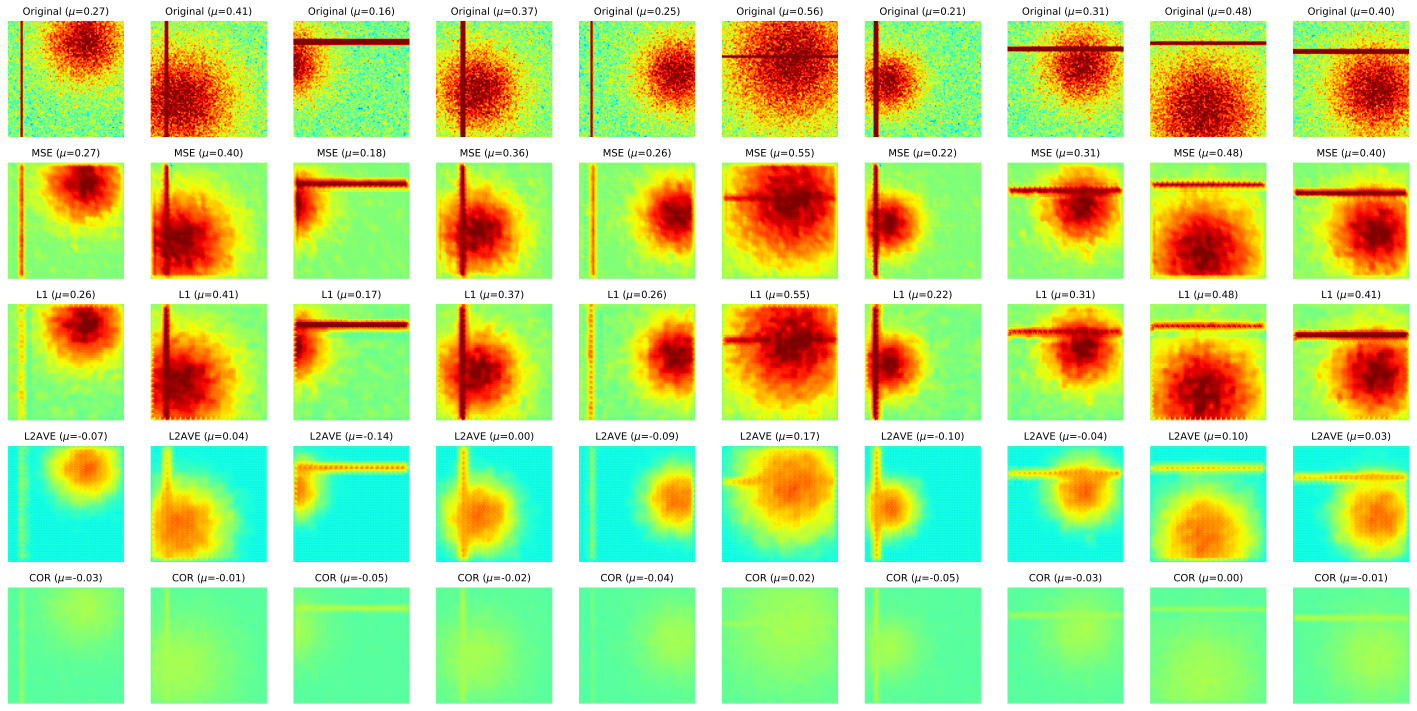

In [12]:
fig, axs = plt.subplots(5, 10, figsize=(20, 10))

# First row: Original images
for i in range(10):
    G = torch.squeeze(X[i, 0, :, :]).detach()  # Original image
    axs[0, i].imshow(G, vmin=-1, vmax=1, cmap='jet')
    axs[0, i].axis('off')
    axs[0, i].set_title(f'Original ($\\mu$={torch.mean(G).item():.2f})', fontsize=10)

# Subsequent rows: Outputs for different loss functions
loss_types = ['mse', 'l1', 'l2ave', 'cor']

for row, loss_type in enumerate(loss_types, start=1):  # Rows 1 to 4
    net = nets[row - 1]  # Select corresponding network
    yHat = net(X)        # Reconstructed outputs

    for i in range(10):
        O = torch.squeeze(yHat[i, 0, :, :]).detach()  # Output image
        axs[row, i].imshow(O, vmin=-1, vmax=1, cmap='jet')
        axs[row, i].axis('off')
        axs[row, i].set_title(f'{loss_type.upper()} ($\\mu$={torch.mean(O).item():.2f})', fontsize=10)

plt.tight_layout()
plt.show()
